<a href="https://colab.research.google.com/github/AnIsAsPe/ClasificadorClientesTelecom/blob/master/Confort_en_ambientes_de_trabajo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Condiciones de confort en ambientes laborales

## 0. Cargar Bibliotecas

In [1]:
!pip install -U yellowbrick

Requirement already up-to-date: yellowbrick in /usr/local/lib/python3.6/dist-packages (1.1)


In [2]:
import pandas as pd
import numpy as np



from sklearn.preprocessing import MinMaxScaler, StandardScaler  #estandarizar varibles
from sklearn.decomposition import PCA   # análisis de componentes principales
from sklearn.cluster import KMeans
from sklearn import metrics
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

from google.colab import files  #funcion para subir archivo csv a google colab

import seaborn as sns
import matplotlib.pyplot as plt



/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Subir archivo de datos

## Leer datos y convertirlos a Data Frame

In [3]:
df = pd.read_csv('train_input_2yaM34J.csv',
                    index_col=['ID'], parse_dates=['Date'])
df


,Date,Temperature,Humidity,Humex,CO2,Bright
ID,,,,,,
0,2017-08-31 23:30:00,22.7,56.0,25.7,534.0,1.0
1,2017-09-01 00:30:00,22.8,55.0,25.7,506.0,1.0
2,2017-09-01 01:30:00,22.9,55.0,25.9,577.0,1.0
3,2017-09-01 02:30:00,23.0,55.0,26.1,630.0,1.0
4,2017-09-01 03:30:00,23.0,55.0,26.1,643.0,1.0
...,...,...,...,...,...,...
7995,2018-02-18 17:30:00,20.5,26.0,18.4,390.0,5.0
7996,2018-02-18 18:00:00,20.4,26.0,18.3,383.0,2.0
7997,2018-02-18 18:30:00,20.3,26.0,18.2,377.0,1.0


# Exploración de datos

In [4]:
datos = df.copy()
datos.drop(['Date'],axis= 1, inplace=True)
datos.head(3)

,Temperature,Humidity,Humex,CO2,Bright
ID,,,,,
0,22.7,56.0,25.7,534.0,1.0
1,22.8,55.0,25.7,506.0,1.0
2,22.9,55.0,25.9,577.0,1.0


In [5]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8000 entries, 0 to 7999
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Temperature  8000 non-null   float64
 1   Humidity     8000 non-null   float64
 2   Humex        8000 non-null   float64
 3   CO2          8000 non-null   float64
 4   Bright       8000 non-null   float64
dtypes: float64(5)
memory usage: 375.0 KB


## ¿Existen casos faltantes?




En caso afirmativo:
1. Remover renglones con valores faltantes

  `dropna()`
2. Imputar valores faltante con el promedio, la mediana o la moda de la columna.

  `fillna(df.columna.mean()`
3. Valor estimado mediante otro modelo de aprendizaje de máquina.

In [6]:
datos.isna().sum()

Temperature    0
Humidity       0
Humex          0
CO2            0
Bright         0
dtype: int64

## Distribución y correlación entre variables

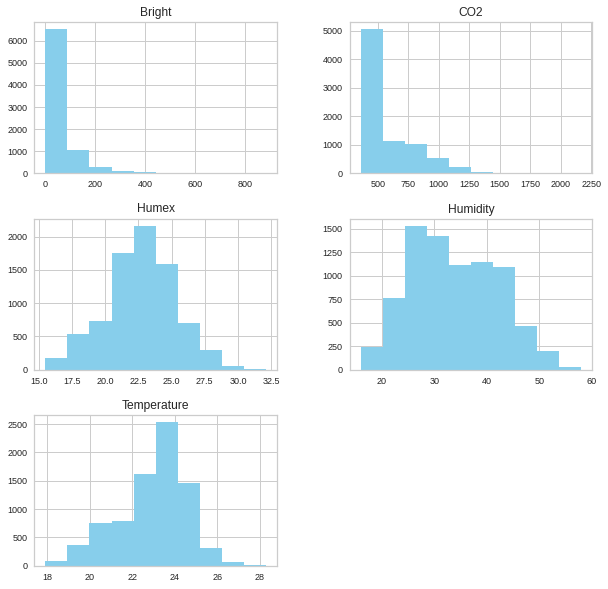

In [7]:
datos.hist(figsize = (10,10), xlabelsize=9, ylabelsize=9,
                               color='skyblue')
plt.show()

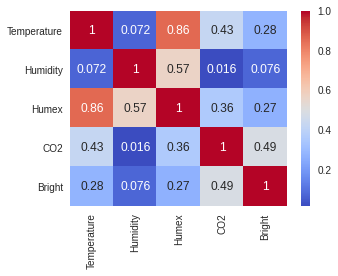

In [8]:
def correlacion(dataframe, grafica = True):
    corr=dataframe.corr()                #creamos la matriz de correlación
    fig = plt.figure(figsize = (5, 4))
    if grafica == True:
        sns.heatmap(corr, cmap="coolwarm", annot=True, square=False)
        fig.tight_layout()
    return corr
correlaciones = correlacion(datos)

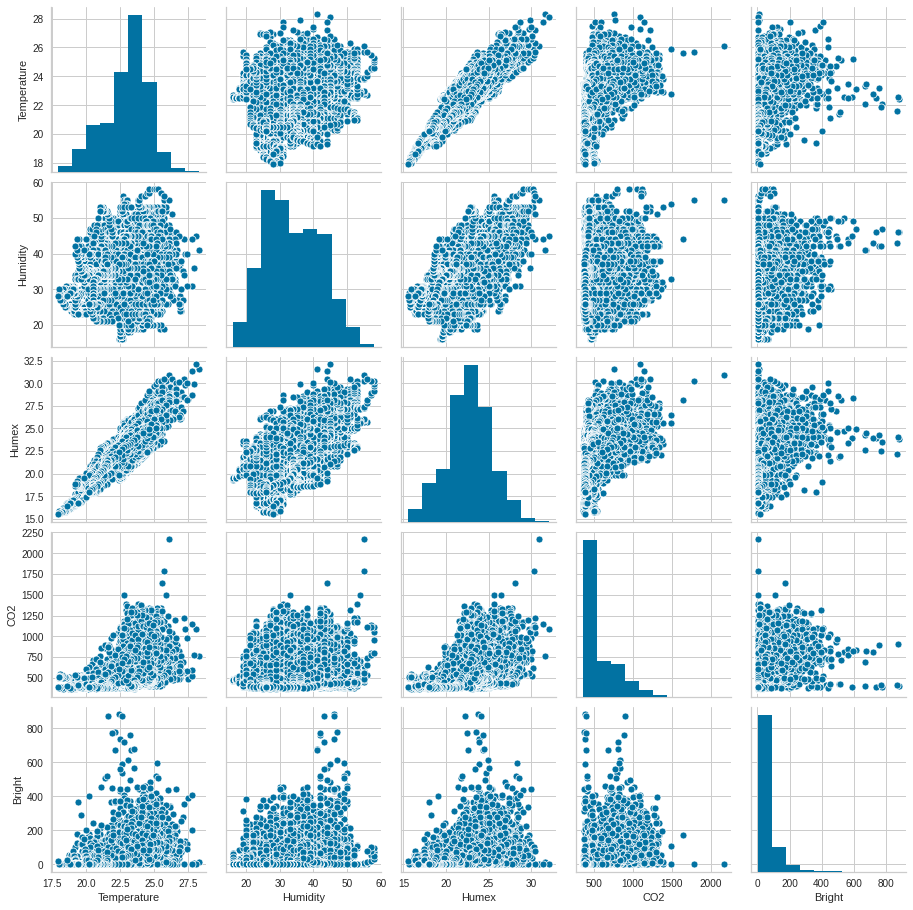

In [9]:
g = sns.pairplot(datos, palette ='Dark2')

plt.show()

## Unificar escalas de medición de cada variable

In [10]:
datos_escalados = datos.copy()
columnas = datos.columns

escala = MinMaxScaler()


datos_escalados[columnas] = escala.fit_transform(datos[columnas])
datos_escalados


,Temperature,Humidity,Humex,CO2,Bright
ID,,,,,
0,0.461538,0.952381,0.614458,0.095739,0.000000
1,0.471154,0.928571,0.614458,0.080243,0.000000
2,0.480769,0.928571,0.626506,0.119535,0.000000
3,0.490385,0.928571,0.638554,0.148866,0.000000
4,0.490385,0.928571,0.638554,0.156060,0.000000
...,...,...,...,...,...
7995,0.250000,0.238095,0.174699,0.016049,0.004540
7996,0.240385,0.238095,0.168675,0.012175,0.001135
7997,0.230769,0.238095,0.162651,0.008854,0.000000


# Análisis de Componentes Principales

In [11]:
pca = PCA()
componentes = pca.fit_transform(datos_escalados) #devuelve np array
num_componentes = datos_escalados.shape[1]
nombres_col = ['componente'+str(i+1) for i in range(num_componentes)]
componentes = pd.DataFrame(data = componentes, columns = nombres_col)
componentes

,componente1,componente2,componente3,componente4,componente5
0,0.405971,0.387037,-0.014875,-0.040003,-0.007500
1,0.393608,0.368407,-0.032314,-0.030314,-0.006268
2,0.412526,0.349564,-0.007412,-0.051269,-0.003219
3,0.429686,0.333582,0.009855,-0.066777,-0.000167
4,0.430955,0.331516,0.015368,-0.070712,-0.000169
...,...,...,...,...,...
7995,-0.403533,0.077857,-0.006081,0.019222,0.007892
7996,-0.412829,0.085927,-0.006798,0.018062,0.009287
7997,-0.421778,0.093548,-0.005905,0.018497,0.010675
7998,-0.432982,0.099836,0.002699,0.015543,0.007611


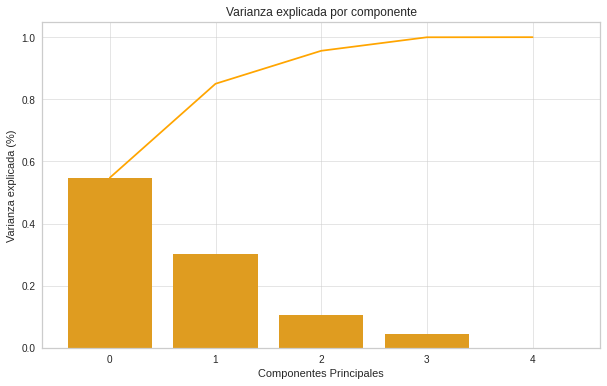

In [12]:
ind = list(range(num_componentes))
var_exp = pca.explained_variance_ratio_
var_acumulada = np.cumsum(var_exp)

plt.figure(figsize=(10,6))

ax = sns.barplot(ind, var_exp, color='orange', ci=None)
ax2 = sns.lineplot(ind, var_acumulada, color='orange', ci=None)
ax.grid(b=True, which='major', linewidth=0.5)

ax.set_xlabel("Componentes Principales")
ax.set_ylabel("Varianza explicada (%)")
plt.title('Varianza explicada por componente');


In [13]:
var_acumulada

array([0.54759734, 0.8500373 , 0.95616002, 0.99969582, 1.        ])

In [14]:
componentes = componentes[componentes.columns[0:2]]
componentes

,componente1,componente2
0,0.405971,0.387037
1,0.393608,0.368407
2,0.412526,0.349564
3,0.429686,0.333582
4,0.430955,0.331516
...,...,...
7995,-0.403533,0.077857
7996,-0.412829,0.085927
7997,-0.421778,0.093548
7998,-0.432982,0.099836


# Selección del número de clústers 

### Elbow Method

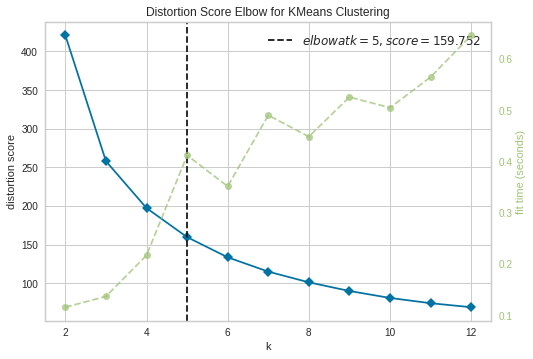

In [15]:

codo = KElbowVisualizer(KMeans(random_state=37), k=12)
codo.fit(componentes)
codo.poof()

### Coeficiente de Silhouette

El coeficiente de Silhouette evalúa la cercania entre puntos de un mismo cluster al mismo tiempo que la distancia a los clusters vecinos.
 
El coeficiente de Silhouette oscila entre -1 y 1 donde 1 indica un clúster de alta densidad y -1 que no existe densidad alguna.

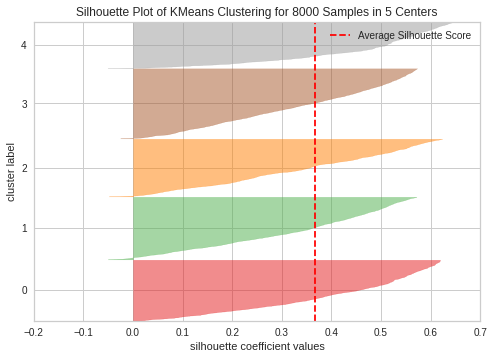

In [16]:
model = KMeans(5)
graf_sil = SilhouetteVisualizer(model)
graf_sil.fit(componentes)
graf_sil.poof()

# K means

In [17]:
model = KMeans(n_clusters = 5, random_state=37).fit(componentes)
clusters = model.predict(componentes)

In [18]:
datos.insert(0, 'componente1', componentes['componente1'])
datos.insert(1, 'componente2', componentes['componente2'])
datos.insert(2, 'cluster', clusters+1)
datos

,componente1,componente2,cluster,Temperature,Humidity,Humex,CO2,Bright
ID,,,,,,,,
0,0.405971,0.387037,4,22.7,56.0,25.7,534.0,1.0
1,0.393608,0.368407,4,22.8,55.0,25.7,506.0,1.0
2,0.412526,0.349564,4,22.9,55.0,25.9,577.0,1.0
3,0.429686,0.333582,4,23.0,55.0,26.1,630.0,1.0
4,0.430955,0.331516,4,23.0,55.0,26.1,643.0,1.0
...,...,...,...,...,...,...,...,...
7995,-0.403533,0.077857,2,20.5,26.0,18.4,390.0,5.0
7996,-0.412829,0.085927,2,20.4,26.0,18.3,383.0,2.0
7997,-0.421778,0.093548,2,20.3,26.0,18.2,377.0,1.0


In [19]:
datos.cluster.value_counts(sort=False)

4    1689
1    1889
5    1635
2    1233
3    1554
Name: cluster, dtype: int64

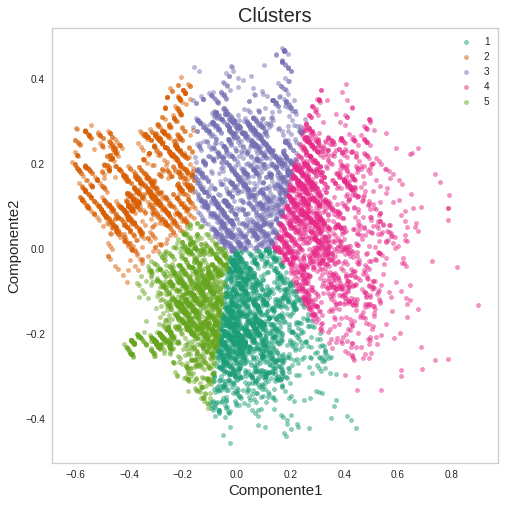

In [21]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Componente1', fontsize = 15)
ax.set_ylabel('Componente2', fontsize = 15)
ax.set_title('Clústers', fontsize = 20)
lista_clusters = sorted(datos.cluster.unique())
sns.set_palette('Dark2')
for cluster in lista_clusters:
    indicesToKeep = datos['cluster'] == cluster 
    ax.scatter(datos.loc[indicesToKeep, 'componente1']
               , datos.loc[indicesToKeep, 'componente2']
               , s = 20, alpha=.5)
ax.legend(lista_clusters)
ax.grid()

In [22]:
mediciones = ['cluster', 'Temperature', 'Humidity', 'Humex', 'CO2', 'Bright']

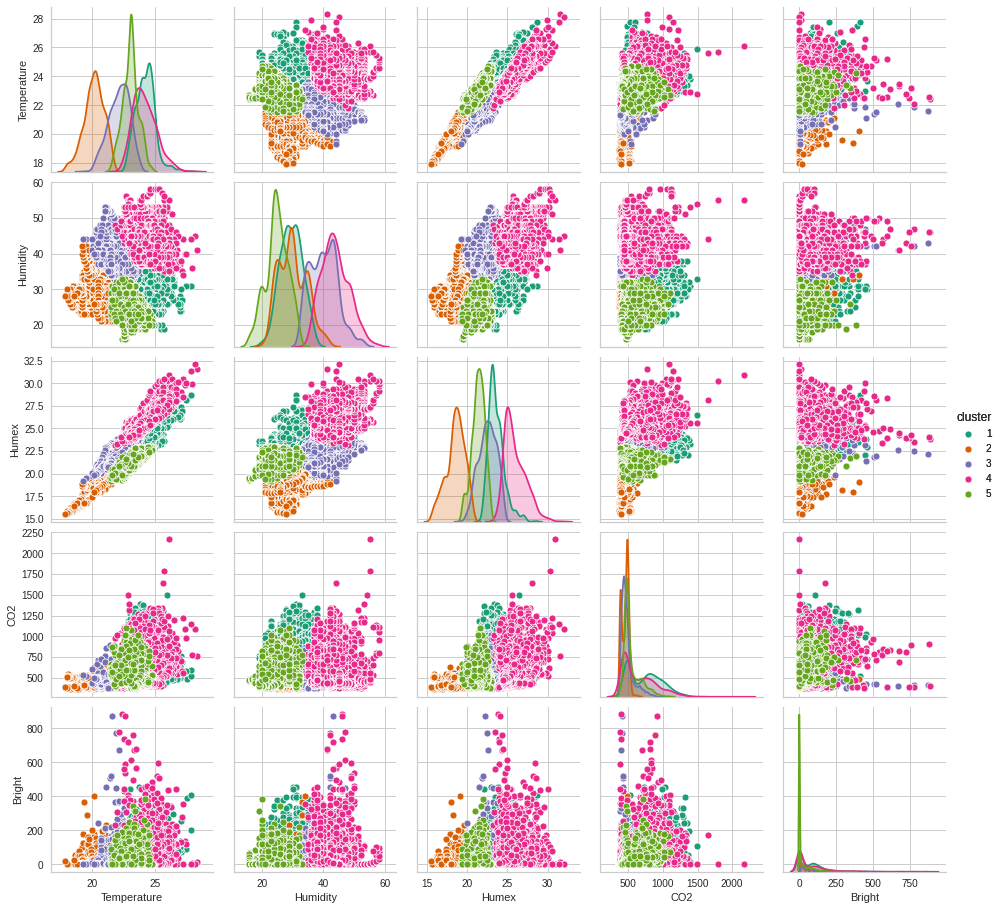

In [23]:

sns.set_palette('Dark2')
g = sns.pairplot(datos[mediciones], hue='cluster')
g.add_legend()
plt.show()